In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [191]:
df = pd.read_csv('/content/drive/MyDrive/UU/ETH-USD (BaoCao).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990


In [192]:

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

In [193]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [194]:

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [195]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1920 non-null   float64
 1   High       1920 non-null   float64
 2   Low        1920 non-null   float64
 3   Close      1920 non-null   float64
 4   Adj Close  1920 non-null   float64
 5   Volume     1920 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 105.0 KB


In [196]:


cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']  # Correct the column name 'Adj Close'
df = df[cols]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990


In [197]:




from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def calculate_vif(df):
    """Calculate Variance Inflation Factor (VIF) for each variable."""
    vif_df = pd.DataFrame()
    vif_df["variables"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

def cointegration_test(df, alpha=0.05, max_vif=10):
    """Perform Johanson's Cointegration Test and Report Summary"""
    # Convert numeric columns to float
    df_numeric = df.select_dtypes(include=['number']).astype(float)

    # Drop any columns with all zero values
    df_numeric = df_numeric.loc[:, (df_numeric != 0).any(axis=0)]

    # Drop constant columns to handle perfect multicollinearity
    df_numeric = df_numeric.loc[:, (df_numeric != df_numeric.iloc[0]).any()]

    # Calculate VIF and drop columns with VIF higher than the threshold
    while True:
        vif_df = calculate_vif(df_numeric)
        max_vif_value = vif_df['VIF'].max()
        if max_vif_value > max_vif:
            remove_col = vif_df.sort_values('VIF', ascending=False)['variables'].iloc[0]
            print(f"Removing {remove_col} with VIF {max_vif_value}")
            df_numeric = df_numeric.drop(columns=[remove_col])
        else:
            break

    out = coint_johansen(df_numeric, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    def adjust(val, length=6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_numeric.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)

# Example usage with your dataframe df
cointegration_test(df)

Removing Close with VIF inf
Removing High with VIF 4687.121442316028
Removing Low with VIF 1967.2441891579692
Removing Open with VIF 548.7024682751013
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Adj Close ::  14.65     > 12.3212   =>   True
Volume ::  0.0       > 4.1296    =>   False


In [198]:


df = df.sort_values(by='Date', ascending=True)

In [199]:

# Train, test
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

time_series = df[cols]
train_data = time_series[:int(0.9*len(time_series))]
test_data = time_series[int(0.9*len(time_series)):]

Error fitting model with lag 1. Skipping.


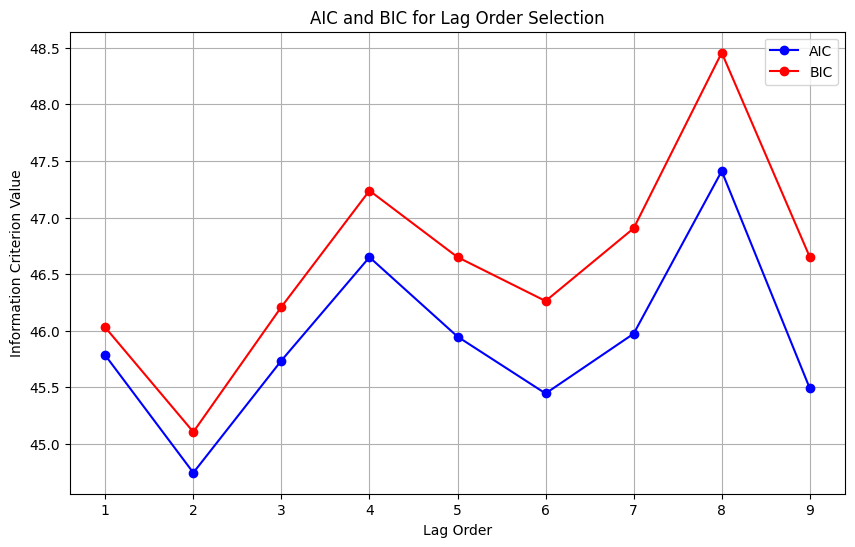

Optimal lag order based on AIC: 2
Optimal lag order based on BIC: 2


In [200]:




from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic
import numpy as np

# Tạo danh sách các giá trị lag order cần kiểm tra
maxlags = 10  # Số lượng lag order tối đa để kiểm tra

# Khởi tạo list để lưu trữ các giá trị AIC và BIC
aic_values = []
bic_values = []

for lag in range(1, maxlags+1):
    model = VAR(train_data)
    try:
        results = model.fit(lag)
        aic_values.append(results.aic)
        bic_values.append(results.bic)
    except np.linalg.LinAlgError:
        print(f"Error fitting model with lag {lag}. Skipping.")
        continue  # Skip to the next lag if an error occurs

# Vẽ đồ thị AIC và BIC (only if any models were successfully fit)
if aic_values:  # Check if aic_values is not empty
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(range(1, len(aic_values) + 1), aic_values, marker='o', linestyle='-', color='b', label='AIC')
    plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='r', label='BIC')
    plt.xlabel('Lag Order')
    plt.ylabel('Information Criterion Value')
    plt.title('AIC and BIC for Lag Order Selection')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Tìm lag order tối ưu dựa trên AIC hoặc BIC
    optimal_lag_aic = np.argmin(aic_values) + 1  # +1 vì index bắt đầu từ 0
    optimal_lag_bic = np.argmin(bic_values) + 1  # +1 vì index bắt đầu từ 0

    print(f'Optimal lag order based on AIC: {optimal_lag_aic}')
    print(f'Optimal lag order based on BIC: {optimal_lag_bic}')
else:
    print("No models could be fit successfully. Check for multicollinearity or singularity issues in your data.")

In [201]:

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [202]:
# ADF Test on each column
df_diff = df.diff().dropna()  # Calculate first differences and drop missing values

for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.8376
 No. Lags Chosen       = 16
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3895
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [203]:
import warnings
warnings.filterwarnings("ignore")

In [204]:

df_diff = train_data.diff().dropna()
df_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-02,-0.486161,-1.810471,-3.998398,-2.236664,-2.236664,-8.948399e+06
2019-03-03,-1.563964,-1.335510,-1.107529,-1.957535,-1.957535,-2.928024e+08
2019-03-04,-2.628235,-3.120148,-5.926155,-4.475296,-4.475296,5.537973e+08
2019-03-05,-4.364930,5.500839,1.332596,10.048264,10.048264,7.566786e+08
2019-03-06,10.165787,1.738846,9.410622,0.966964,0.966964,-1.757958e+08
...,...,...,...,...,...,...
2023-11-18,-0.196289,-18.588257,10.616943,2.004272,2.004272,-3.816972e+09
2023-11-19,1.508789,44.171631,23.838501,49.919434,49.919434,-3.486282e+08
2023-11-20,48.673340,50.776001,51.143433,9.034668,9.034668,5.150416e+09


In [205]:
# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4023
 No. Lags Chosen       = 16
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4457
 No. Lags Chosen       = 22
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [206]:


model = VAR(df_diff)

In [207]:




import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming df_diff is your differenced DataFrame

# ADF Test on each column
for name, column in df_diff.items():
    result = adfuller(column) # Remove the 'name' argument
    print(f'ADF Statistic for {name}: {result[0]}') # Use f-string to print the name
    print(f'p-value: {result[1]}')
    print('\n')

# Check for multicollinearity
correlation_matrix = df_diff.corr()
print(correlation_matrix)

ADF Statistic for Open: -10.40227188790488
p-value: 1.895868937765401e-18


ADF Statistic for High: -8.44574218567231
p-value: 1.7148094928273375e-13


ADF Statistic for Low: -11.926407995181933
p-value: 4.895329870336608e-22


ADF Statistic for Close: -10.45766269560758
p-value: 1.38510036324293e-18


ADF Statistic for Adj Close: -10.45766269560758
p-value: 1.38510036324293e-18


ADF Statistic for Volume: -10.340202766686676
p-value: 2.6976574315828023e-18


               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.585259  0.366258 -0.078370  -0.078370  0.095507
High       0.585259  1.000000  0.450419  0.489071   0.489071  0.234524
Low        0.366258  0.450419  1.000000  0.615948   0.615948 -0.424357
Close     -0.078370  0.489071  0.615948  1.000000   1.000000 -0.164355
Adj Close -0.078370  0.489071  0.615948  1.000000   1.000000 -0.164355
Volume     0.095507  0.234524 -0.424357 -0.164355  -0.164355  1.000000


In [208]:
fitted_model = model.fit() # Fit the VAR model and store it

lag_order = fitted_model.k_ar
print(lag_order)

1


In [209]:

predictions = fitted_model.forecast(df_diff.values[-lag_order:], steps=len(test_data))
predictions

array([[ 1.27991388e+02,  3.80842730e+01,  6.88652797e+01,
        -9.46939526e+00, -9.46939526e+00,  7.13295201e+08],
       [-1.06833066e+01,  1.13532881e+01, -6.95191101e+00,
         4.92806132e+00,  4.92806132e+00, -8.37628853e+07],
       [ 5.29584493e+00, -4.37912161e+00,  2.12227756e+00,
        -6.99939543e-01, -6.99939543e-01,  2.50760854e+08],
       ...,
       [ 1.11149957e+00,  1.15713883e+00,  1.07898828e+00,
         1.11365384e+00,  1.11365384e+00,  6.03057160e+06],
       [ 1.11149957e+00,  1.15713883e+00,  1.07898828e+00,
         1.11365384e+00,  1.11365384e+00,  6.03057160e+06],
       [ 1.11149957e+00,  1.15713883e+00,  1.07898828e+00,
         1.11365384e+00,  1.11365384e+00,  6.03057160e+06]])

In [210]:





# Calculate the starting index based on the length of the predictions array
start_index = len(df) - len(predictions)

df_forecast = pd.DataFrame(predictions, index=df.index[start_index:], columns=[col + '_1d' for col in df.columns])
df_forecast

,Open_1d,High_1d,Low_1d,Close_1d,Adj Close_1d,Volume_1d
Date,,,,,,
2023-11-23,127.991388,38.084273,68.865280,-9.469395,-9.469395,7.132952e+08
2023-11-24,-10.683307,11.353288,-6.951911,4.928061,4.928061,-8.376289e+07
2023-11-25,5.295845,-4.379122,2.122278,-0.699940,-0.699940,2.507609e+08
2023-11-26,-0.944722,3.783094,2.069224,2.374631,2.374631,-1.714631e+08
2023-11-27,2.529693,0.165816,-0.006954,0.349556,0.349556,1.080681e+08
...,...,...,...,...,...,...
2024-05-28,1.111500,1.157139,1.078988,1.113654,1.113654,6.030572e+06
2024-05-29,1.111500,1.157139,1.078988,1.113654,1.113654,6.030572e+06
2024-05-30,1.111500,1.157139,1.078988,1.113654,1.113654,6.030572e+06


In [211]:



def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns  # Get the actual column names from df_train
    for col in columns:
        # Use the correct column names from df_train when creating forecasted columns
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(train_data, df_forecast)
# Now, define fc_cols based on the actual forecasted column names
fc_cols = [col + '_forecast' for col in train_data.columns]
df_results = df_results[fc_cols]
df_results

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
Date,,,,,,
2023-11-23,2061.574518,2127.598433,2002.028244,2054.955898,2054.955898,1.408550e+10
2023-11-24,2050.891212,2138.951721,1995.076333,2059.883959,2059.883959,1.400173e+10
2023-11-25,2056.187057,2134.572599,1997.198610,2059.184020,2059.184020,1.425249e+10
2023-11-26,2055.242335,2138.355694,1999.267834,2061.558651,2061.558651,1.408103e+10
2023-11-27,2057.772028,2138.521509,1999.260880,2061.908207,2061.908207,1.418910e+10
...,...,...,...,...,...,...
2024-05-28,2260.627936,2350.540711,2197.215217,2265.984480,2265.984480,1.525768e+10
2024-05-29,2261.739436,2351.697850,2198.294205,2267.098134,2267.098134,1.526371e+10
2024-05-30,2262.850935,2352.854989,2199.373194,2268.211788,2268.211788,1.526974e+10


In [212]:

# Forecasting 30 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=30)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=30, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_30days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_30days.head())

              Open_1d    High_1d     Low_1d  Close_1d  Adj Close_1d  \
2024-06-02  51.486711  44.649427  32.991089 -5.185828     -5.185828   
2024-06-03  -4.564562  -9.574652 -13.027222 -0.361221     -0.361221   
2024-06-04  -0.914385   3.689426   8.895297  3.244182      3.244182   
2024-06-05   3.604822   0.879688  -3.360779 -0.186995     -0.186995   
2024-06-06  -0.409168   1.043538   3.736363  1.799677      1.799677   

               Volume_1d  
2024-06-02  8.293939e+08  
2024-06-03  4.365100e+08  
2024-06-04 -3.033815e+08  
2024-06-05  1.583977e+08  
2024-06-06 -6.259509e+07  


In [213]:


def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Create forecasted columns using '_forecast' suffix
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results_30days = invert_transformation(test_data, df_forecast_30days)

# Define fc_cols based on the actual forecasted column names in df_results_30days
fc_cols = [col for col in df_results_30days.columns if '_forecast' in col]
df_results_30days = df_results_30days[fc_cols]
df_results_30days.head()

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.370988,3873.944105,3782.831177,3808.013147,3808.013147,9.490418e+09
2024-06-03,3806.806426,3864.369453,3769.803956,3807.651926,3807.651926,9.926928e+09
2024-06-04,3805.892041,3868.058879,3778.699253,3810.896108,3810.896108,9.623547e+09
2024-06-05,3809.496863,3868.938566,3775.338473,3810.709114,3810.709114,9.781945e+09
2024-06-06,3809.087696,3869.982105,3779.074837,3812.508790,3812.508790,9.719350e+09


In [214]:
df_results_30days = invert_transformation(test_data, df_forecast_30days)
df_results_30days = df_results_30days[fc_cols]
df_results_30days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.370988,3873.944105,3782.831177,3808.013147,3808.013147,9.490418e+09
2024-06-03,3806.806426,3864.369453,3769.803956,3807.651926,3807.651926,9.926928e+09
2024-06-04,3805.892041,3868.058879,3778.699253,3810.896108,3810.896108,9.623547e+09
2024-06-05,3809.496863,3868.938566,3775.338473,3810.709114,3810.709114,9.781945e+09
2024-06-06,3809.087696,3869.982105,3779.074837,3812.508790,3812.508790,9.719350e+09
2024-06-07,3811.012022,3871.280048,3778.563466,3813.271494,3813.271494,9.756781e+09
2024-06-08,3811.700982,3872.328946,3780.580833,3814.565986,3814.565986,9.747959e+09
2024-06-09,3813.033331,3873.560709,3781.115207,3815.585429,3815.585429,9.761175e+09
2024-06-10,3814.028394,3874.669185,3782.505904,3816.748476,3816.748476,9.763702e+09
2024-06-11,3815.201571,3875.856817,3783.408446,3817.836181,3817.836181,9.771439e+09


In [215]:

# Forecasting 60 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=60)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=60, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_60days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_60days.head())

              Open_1d    High_1d     Low_1d  Close_1d  Adj Close_1d  \
2024-06-02  51.486711  44.649427  32.991089 -5.185828     -5.185828   
2024-06-03  -4.564562  -9.574652 -13.027222 -0.361221     -0.361221   
2024-06-04  -0.914385   3.689426   8.895297  3.244182      3.244182   
2024-06-05   3.604822   0.879688  -3.360779 -0.186995     -0.186995   
2024-06-06  -0.409168   1.043538   3.736363  1.799677      1.799677   

               Volume_1d  
2024-06-02  8.293939e+08  
2024-06-03  4.365100e+08  
2024-06-04 -3.033815e+08  
2024-06-05  1.583977e+08  
2024-06-06 -6.259509e+07  


In [216]:

df_results_60days = invert_transformation(test_data, df_forecast_60days)
df_results_60days = df_results_60days[fc_cols]
df_results_60days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.370988,3873.944105,3782.831177,3808.013147,3808.013147,9.490418e+09
2024-06-03,3806.806426,3864.369453,3769.803956,3807.651926,3807.651926,9.926928e+09
2024-06-04,3805.892041,3868.058879,3778.699253,3810.896108,3810.896108,9.623547e+09
2024-06-05,3809.496863,3868.938566,3775.338473,3810.709114,3810.709114,9.781945e+09
2024-06-06,3809.087696,3869.982105,3779.074837,3812.508790,3812.508790,9.719350e+09
2024-06-07,3811.012022,3871.280048,3778.563466,3813.271494,3813.271494,9.756781e+09
2024-06-08,3811.700982,3872.328946,3780.580833,3814.565986,3814.565986,9.747959e+09
2024-06-09,3813.033331,3873.560709,3781.115207,3815.585429,3815.585429,9.761175e+09
2024-06-10,3814.028394,3874.669185,3782.505904,3816.748476,3816.748476,9.763702e+09
2024-06-11,3815.201571,3875.856817,3783.408446,3817.836181,3817.836181,9.771439e+09


In [217]:

# Forecasting 90 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=90)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=90, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_90days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_90days.head())

              Open_1d    High_1d     Low_1d  Close_1d  Adj Close_1d  \
2024-06-02  51.486711  44.649427  32.991089 -5.185828     -5.185828   
2024-06-03  -4.564562  -9.574652 -13.027222 -0.361221     -0.361221   
2024-06-04  -0.914385   3.689426   8.895297  3.244182      3.244182   
2024-06-05   3.604822   0.879688  -3.360779 -0.186995     -0.186995   
2024-06-06  -0.409168   1.043538   3.736363  1.799677      1.799677   

               Volume_1d  
2024-06-02  8.293939e+08  
2024-06-03  4.365100e+08  
2024-06-04 -3.033815e+08  
2024-06-05  1.583977e+08  
2024-06-06 -6.259509e+07  


In [218]:

df_results_90days = invert_transformation(test_data, df_forecast_90days)
df_results_90days = df_results_90days[fc_cols]
df_results_90days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,3811.370988,3873.944105,3782.831177,3808.013147,3808.013147,9.490418e+09
2024-06-03,3806.806426,3864.369453,3769.803956,3807.651926,3807.651926,9.926928e+09
2024-06-04,3805.892041,3868.058879,3778.699253,3810.896108,3810.896108,9.623547e+09
2024-06-05,3809.496863,3868.938566,3775.338473,3810.709114,3810.709114,9.781945e+09
2024-06-06,3809.087696,3869.982105,3779.074837,3812.508790,3812.508790,9.719350e+09
...,...,...,...,...,...,...
2024-08-26,3899.654164,3963.787772,3865.475086,3902.482811,3902.482811,1.022920e+10
2024-08-27,3900.765663,3964.944911,3866.554075,3903.596465,3903.596465,1.023524e+10
2024-08-28,3901.877163,3966.102049,3867.633063,3904.710119,3904.710119,1.024127e+10
2024-08-29,3902.988662,3967.259188,3868.712051,3905.823772,3905.823772,1.024730e+10


In [219]:
predict_data_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df)+59, step=1)
predict_data_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df)+89, step=1)

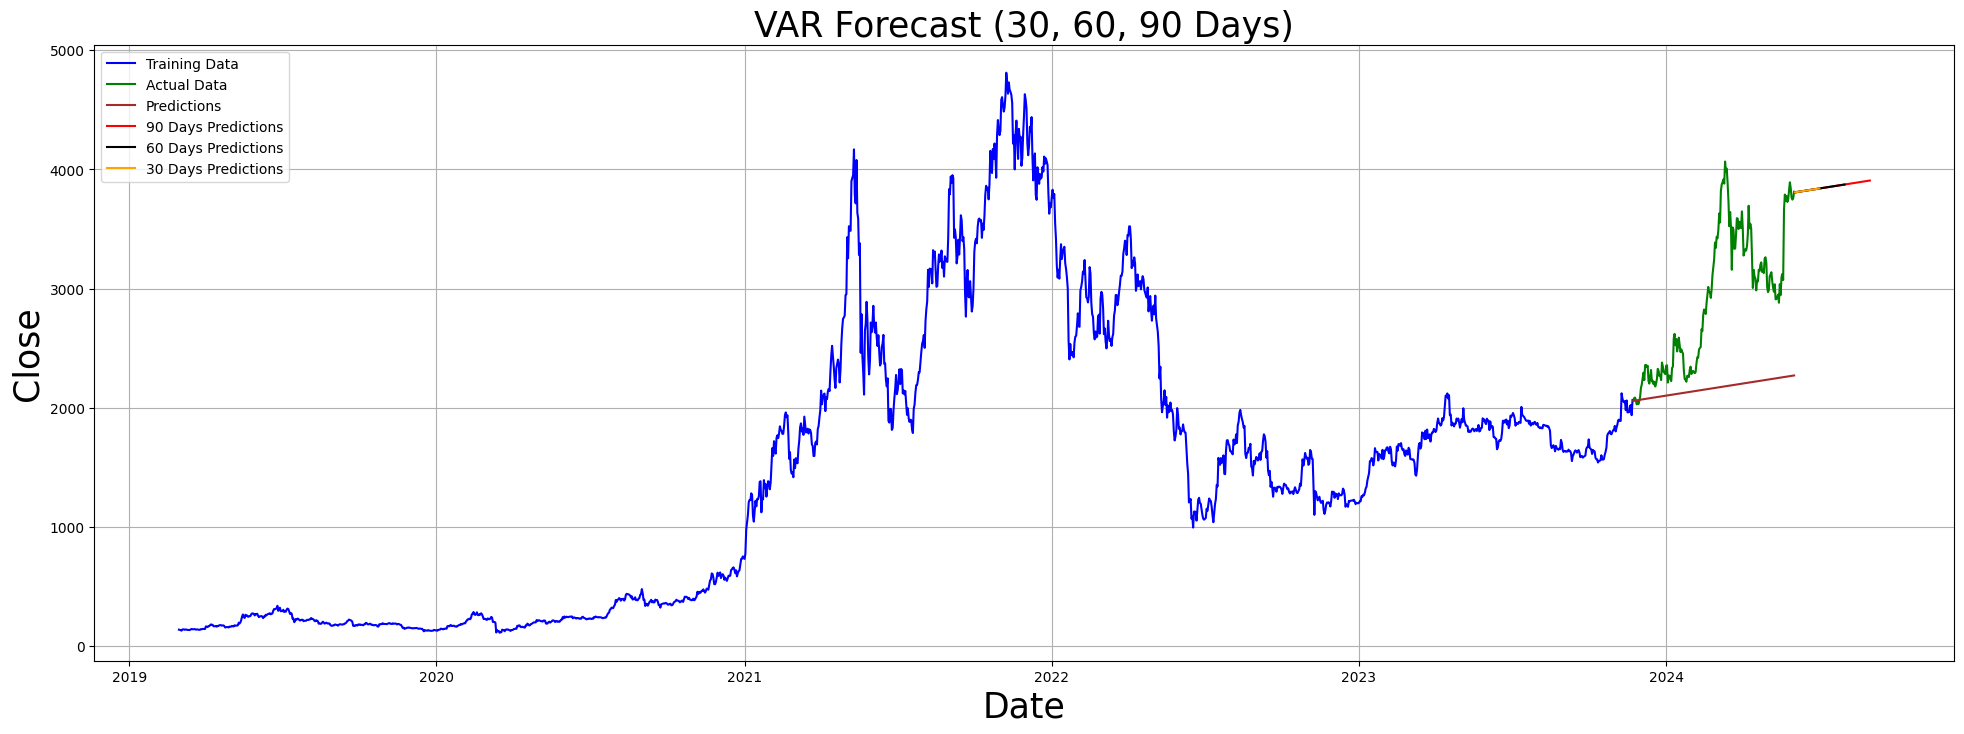

In [220]:


import matplotlib.pyplot as plt

# Assuming df_results_30days, df_results_60days, df_results_90days are your DataFrames containing forecast results
# Define the date range for plotting
start_date = '2019-01-03'
end_date = '2024-08-30'

# Plotting the data
plt.figure(figsize=(24, 8))

# Plotting the training data
plt.plot(train_data.index, train_data.Close, label='Training Data', color='blue')

# Plotting the actual test data
plt.plot(test_data.index, test_data.Close, label='Actual Data', color='green')
# Plotting the prediction data
plt.plot(test_data.index, df_results.Close_forecast, label='Predictions', color ='brown')
# Plotting the forecast results

plt.plot(df_results_90days.index, df_results_90days.Close_forecast, label='90 Days Predictions', color='red')

plt.plot(df_results_60days.index, df_results_60days.Close_forecast, label='60 Days Predictions', color='black')
plt.plot(df_results_30days.index, df_results_30days.Close_forecast, label='30 Days Predictions', color='orange')
# Adding title and labels
plt.title('VAR Forecast (30, 60, 90 Days)', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Close', fontsize=25)

# Adding legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [221]:

y_test = test_data.Close
y_pred = df_results.Close_forecast

In [222]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



test_91_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_91_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_91_mse = np.mean((np.array(y_test) - np.array(y_pred))**2)
print('Testing RMSE:', test_91_rmse)
print('Testing MAPE:', test_91_mape)
print('Testing MSE:', test_91_mse)

Testing RMSE: 903.8740706891134
Testing MAPE: 22.638213600497696
Testing MSE: 816988.3356641084
